<a href="https://colab.research.google.com/github/InnaK342/nn2022/blob/main/Lab6/lb6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторна робота №6
##Завдання

Виконати вирішення задачі класифікації для 3 класів з набору даних food101 з використанням різних моделей нейронних мереж: 
1. CNN модель з лабораторної роботи 4 1.2. Resnet модель 1.3. Efficientnet модель (моделі 1.1-1.3 з використанням оптимізатора Adam) 1.4. (1.5) Моделі 1.2,1.3 з використанням оптимізатора SGD. 1.6. (1.7) Моделі 1.2,1.3 отримані за допомогою tf.keras.applications та треновані з використанням fine-tuning (останні 10 шарів)
2. Індекси класів визначити індивідуально за залежностями: i1=n-1,i2=n+29,i3=n+59 (де і1,і2,і3 - індекс класу (починаючи з 0) у відсортованому за алфавітом наборі даних, n - номер за списком групи.
3. Порівняти результати моделювання із використанням TensorBoard
4. Графік(и) порівняння результатів завантажити у форматі .svg та вставити у підсумковий файл поряд із та відповідними висновками

##Завантажимо набір даних

In [ ]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-04-29 14:36:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 172.217.164.176, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   212MB/s    in 6.9s    

2022-04-29 14:36:31 (225 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



##Відберемо класи за варіантом для тренування

In [ ]:
import pathlib
import numpy as np
import os

#Кількість зображень в файлі
data_dir_train = pathlib.Path("101_food_classes_10_percent/train/") 
data_dir_test = pathlib.Path("101_food_classes_10_percent/test/")
num_food_images_train = len(os.listdir(data_dir_train))
print('Count of images are in a file:', num_food_images_train)

#Відберемо 3 задані варіанти
arr_index = [7,37,67]
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
new_class_names = [class_names[arr_index[0]], class_names[arr_index[1]],class_names[arr_index[2]]]
print('Our classes:', new_class_names)

Count of images are in a file: 101
Our classes: ['bibimbap', 'filet_mignon', 'omelette']


##Залишимо в файлах тільки наші класи

In [ ]:
from pathlib import Path
import shutil

#Видалимо всі класи, окрім заданих
for name in class_names:
  if name != new_class_names[0] and name != new_class_names[1] and name != new_class_names[2]:
    dirpath = Path(data_dir_train) / name
    dirpath_test = Path(data_dir_test) / name
    if dirpath_test.exists() and dirpath_test.is_dir():
        shutil.rmtree(dirpath)
        shutil.rmtree(dirpath_test)
print('Test:', os.listdir(data_dir_test))
print('Train:', os.listdir(data_dir_train))

Test: ['omelette', 'filet_mignon', 'bibimbap']
Train: ['omelette', 'filet_mignon', 'bibimbap']


##Відображення даних

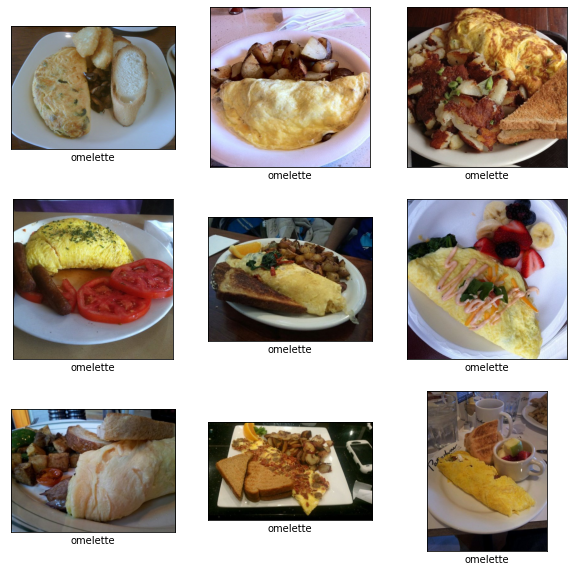

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    target_folder = '101_food_classes_10_percent/train/'+'omelette'
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.xlabel('omelette')
plt.show()

##Нормування та перетворення файлів в дані

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "101_food_classes_10_percent/test/"
test_dir = "101_food_classes_10_percent/train/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


##Підготовка зображень до навчання

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 750 images belonging to 3 classes.


##Навчання мережі(CNN)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.callbacks import TensorBoard

model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax')
])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tensorboard = TensorBoard(log_dir='logs/cnn', histogram_freq=1)

history_model = model.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard])

Epoch 1/10
24/24 [==============================] - 21s 466ms/step - loss: 1.3003 - accuracy: 0.3653 - val_loss: 1.0545 - val_accuracy: 0.4311
Epoch 2/10
24/24 [==============================] - 12s 481ms/step - loss: 0.9962 - accuracy: 0.4640 - val_loss: 0.9784 - val_accuracy: 0.5600
Epoch 3/10
24/24 [==============================] - 11s 462ms/step - loss: 0.9491 - accuracy: 0.5240 - val_loss: 0.9212 - val_accuracy: 0.6133
Epoch 4/10
24/24 [==============================] - 11s 469ms/step - loss: 0.9373 - accuracy: 0.5467 - val_loss: 0.9561 - val_accuracy: 0.5644
Epoch 5/10
24/24 [==============================] - 11s 459ms/step - loss: 0.8889 - accuracy: 0.6040 - val_loss: 0.8608 - val_accuracy: 0.6400
Epoch 6/10
24/24 [==============================] - 11s 457ms/step - loss: 0.8693 - accuracy: 0.6227 - val_loss: 0.8665 - val_accuracy: 0.6178
Epoch 7/10
24/24 [==============================] - 11s 453ms/step - loss: 0.8089 - accuracy: 0.6373 - val_loss: 0.7813 - val_accuracy: 0.6889

In [ ]:
%load_ext tensorboard

##Accuracy

epoch_accuracy.svg

##Loss

epoch_loss.svg

##Навчання мережі Resnet(Adam)

In [ ]:
import tensorflow_hub as hub

model_2 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_2.build([None, 224, 224, 3])  # Batch input shape.

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tensorboard_2 = TensorBoard(log_dir='logs/resnet(adam)', histogram_freq=1,
                          write_graph=True, write_images=False)

history_model_2 = model_2.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_2])

Epoch 1/10
24/24 [==============================] - 30s 918ms/step - loss: 0.8512 - accuracy: 0.6333 - val_loss: 0.5209 - val_accuracy: 0.8133
Epoch 2/10
24/24 [==============================] - 20s 831ms/step - loss: 0.3697 - accuracy: 0.8600 - val_loss: 0.4336 - val_accuracy: 0.8622
Epoch 3/10
24/24 [==============================] - 20s 832ms/step - loss: 0.2731 - accuracy: 0.8933 - val_loss: 0.4091 - val_accuracy: 0.8533
Epoch 4/10
24/24 [==============================] - 20s 830ms/step - loss: 0.2566 - accuracy: 0.9000 - val_loss: 0.3774 - val_accuracy: 0.8667
Epoch 5/10
24/24 [==============================] - 20s 831ms/step - loss: 0.2207 - accuracy: 0.9120 - val_loss: 0.3562 - val_accuracy: 0.8711
Epoch 6/10
24/24 [==============================] - 20s 826ms/step - loss: 0.1773 - accuracy: 0.9440 - val_loss: 0.3512 - val_accuracy: 0.8756
Epoch 7/10
24/24 [==============================] - 20s 835ms/step - loss: 0.1644 - accuracy: 0.9387 - val_loss: 0.3473 - val_accuracy: 0.8933

##Accuracy

epoch_accuracy-2.svg

##Loss

epoch_loss-2.svg

##Навчання мережі EfficientNet(Adam)

In [ ]:
import tensorflow_hub as hub

model_3 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_3.build([None, 224, 224, 3])  # Batch input shape.

model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tensorboard_3 = TensorBoard(log_dir='logs/efficientnet(adam)', histogram_freq=1,
                          write_graph=True, write_images=False)

history_model_3 = model_3.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_3])

Epoch 1/10
24/24 [==============================] - 24s 607ms/step - loss: 0.7772 - accuracy: 0.7107 - val_loss: 0.5059 - val_accuracy: 0.8756
Epoch 2/10
24/24 [==============================] - 13s 558ms/step - loss: 0.3804 - accuracy: 0.9147 - val_loss: 0.3420 - val_accuracy: 0.8978
Epoch 3/10
24/24 [==============================] - 13s 557ms/step - loss: 0.2779 - accuracy: 0.9253 - val_loss: 0.2921 - val_accuracy: 0.9067
Epoch 4/10
24/24 [==============================] - 13s 561ms/step - loss: 0.2379 - accuracy: 0.9307 - val_loss: 0.2596 - val_accuracy: 0.9156
Epoch 5/10
24/24 [==============================] - 13s 552ms/step - loss: 0.1959 - accuracy: 0.9440 - val_loss: 0.2345 - val_accuracy: 0.9200
Epoch 6/10
24/24 [==============================] - 13s 552ms/step - loss: 0.1814 - accuracy: 0.9493 - val_loss: 0.2215 - val_accuracy: 0.9200
Epoch 7/10
24/24 [==============================] - 13s 555ms/step - loss: 0.1534 - accuracy: 0.9600 - val_loss: 0.2137 - val_accuracy: 0.9244

##Accuracy

epoch_accuracy-3.svg

##Loss

epoch_loss-3.svg

##Навчання мережі Resnet(SGD)

In [ ]:
model_4 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_4.build([None, 224, 224, 3])  # Batch input shape.

model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

tensorboard_4 = TensorBoard(log_dir='logs/resnet(sgd)', histogram_freq=1,
                          write_graph=True, write_images=False)

history_model_4 = model_4.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_4])

Epoch 1/10
24/24 [==============================] - 29s 901ms/step - loss: 0.7179 - accuracy: 0.6853 - val_loss: 0.4967 - val_accuracy: 0.8000
Epoch 2/10
24/24 [==============================] - 21s 885ms/step - loss: 0.3348 - accuracy: 0.8693 - val_loss: 0.4021 - val_accuracy: 0.8444
Epoch 3/10
24/24 [==============================] - 20s 853ms/step - loss: 0.2740 - accuracy: 0.8880 - val_loss: 0.3605 - val_accuracy: 0.8533
Epoch 4/10
24/24 [==============================] - 20s 855ms/step - loss: 0.2486 - accuracy: 0.9067 - val_loss: 0.3558 - val_accuracy: 0.8578
Epoch 5/10
24/24 [==============================] - 20s 852ms/step - loss: 0.2220 - accuracy: 0.9133 - val_loss: 0.3840 - val_accuracy: 0.8578
Epoch 6/10
24/24 [==============================] - 20s 850ms/step - loss: 0.1989 - accuracy: 0.9280 - val_loss: 0.3475 - val_accuracy: 0.8489
Epoch 7/10
24/24 [==============================] - 20s 854ms/step - loss: 0.1923 - accuracy: 0.9267 - val_loss: 0.3554 - val_accuracy: 0.8533

##Accuracy

epoch_accuracy-4.svg

##Loss

epoch_loss-4.svg

##Навчання мережі EfficientNet(SGD)

In [ ]:
model_5 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_5.build([None, 224, 224, 3])  # Batch input shape.

model_5.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tensorboard_5 = TensorBoard(log_dir='logs/efficientnet(sgd)', histogram_freq=1,
                          write_graph=True, write_images=False)

history_model_5 = model_5.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_5])

Epoch 1/10
24/24 [==============================] - 22s 580ms/step - loss: 0.7559 - accuracy: 0.7000 - val_loss: 0.4939 - val_accuracy: 0.8444
Epoch 2/10
24/24 [==============================] - 14s 572ms/step - loss: 0.3792 - accuracy: 0.9027 - val_loss: 0.3440 - val_accuracy: 0.8800
Epoch 3/10
24/24 [==============================] - 13s 547ms/step - loss: 0.2729 - accuracy: 0.9253 - val_loss: 0.2886 - val_accuracy: 0.8889
Epoch 4/10
24/24 [==============================] - 13s 547ms/step - loss: 0.2249 - accuracy: 0.9413 - val_loss: 0.2567 - val_accuracy: 0.8933
Epoch 5/10
24/24 [==============================] - 13s 547ms/step - loss: 0.1998 - accuracy: 0.9387 - val_loss: 0.2340 - val_accuracy: 0.9200
Epoch 6/10
24/24 [==============================] - 13s 556ms/step - loss: 0.1786 - accuracy: 0.9600 - val_loss: 0.2215 - val_accuracy: 0.9156
Epoch 7/10
24/24 [==============================] - 13s 545ms/step - loss: 0.1683 - accuracy: 0.9467 - val_loss: 0.2118 - val_accuracy: 0.9244

##Accuracy

epoch_accuracy-5.svg

##Loss

epoch_loss-5.svg

##Навчання мережі Resnet(SGD) Fine-training

In [26]:
resnet_model = tf.keras.applications.resnet.ResNet101(classes=3, weights=None)
for layer in resnet_model.layers:
  layer.trainable = False;

for layer in resnet_model.layers[-10:]:
  layer.trainable = True;

tensorboard_6 = tf.keras.callbacks.TensorBoard(log_dir='logs/resnet(sgd)tunnig', histogram_freq=1,
                                               write_graph=True, write_images=False)

resnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

history_model_6 = resnet_model.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_6])

Epoch 1/10
24/24 [==============================] - 27s 923ms/step - loss: 1.0034 - accuracy: 0.5187 - val_loss: 1.0972 - val_accuracy: 0.3333
Epoch 2/10
24/24 [==============================] - 20s 844ms/step - loss: 0.8911 - accuracy: 0.6040 - val_loss: 1.1227 - val_accuracy: 0.3333
Epoch 3/10
24/24 [==============================] - 20s 844ms/step - loss: 0.8267 - accuracy: 0.6373 - val_loss: 1.1753 - val_accuracy: 0.3333
Epoch 4/10
24/24 [==============================] - 20s 848ms/step - loss: 0.7948 - accuracy: 0.6653 - val_loss: 1.3011 - val_accuracy: 0.3333
Epoch 5/10
24/24 [==============================] - 20s 845ms/step - loss: 0.7722 - accuracy: 0.6613 - val_loss: 1.2718 - val_accuracy: 0.3333
Epoch 6/10
24/24 [==============================] - 20s 849ms/step - loss: 0.7661 - accuracy: 0.6453 - val_loss: 1.2909 - val_accuracy: 0.3333
Epoch 7/10
24/24 [==============================] - 20s 852ms/step - loss: 0.7644 - accuracy: 0.6707 - val_loss: 1.5905 - val_accuracy: 0.3333

##Accuracy

epoch_accuracy-6.svg

##Loss

epoch_loss-6.svg

##Навчання мережі EfficientNet(SGD) Fine-training

In [28]:
eff_model = tf.keras.applications.efficientnet.EfficientNetB0(classes=3, weights=None)
for layer in eff_model.layers:
  layer.trainable = False;

for layer in eff_model.layers[-10:]:
  layer.trainable = True;

tensorboard_7 = tf.keras.callbacks.TensorBoard(log_dir='logs/efficientnet(sgd)tunnig', histogram_freq=1,
                                               write_graph=True, write_images=False)

eff_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

history_model_7 = eff_model.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_7])

Epoch 1/10
24/24 [==============================] - 22s 618ms/step - loss: 1.1007 - accuracy: 0.3240 - val_loss: 1.1002 - val_accuracy: 0.3333
Epoch 2/10
24/24 [==============================] - 13s 538ms/step - loss: 1.1007 - accuracy: 0.3307 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 3/10
24/24 [==============================] - 13s 543ms/step - loss: 1.1008 - accuracy: 0.3307 - val_loss: 1.1002 - val_accuracy: 0.3333
Epoch 4/10
24/24 [==============================] - 13s 540ms/step - loss: 1.1021 - accuracy: 0.3160 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 5/10
24/24 [==============================] - 13s 541ms/step - loss: 1.1030 - accuracy: 0.2853 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 6/10
24/24 [==============================] - 13s 537ms/step - loss: 1.1005 - accuracy: 0.3240 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/10
24/24 [==============================] - 13s 542ms/step - loss: 1.1013 - accuracy: 0.3400 - val_loss: 1.0993 - val_accuracy: 0.3333

##Accuracy

epoch_accuracy-7.svg

##Loss

epoch_loss-7.svg

##Порівняння результатів

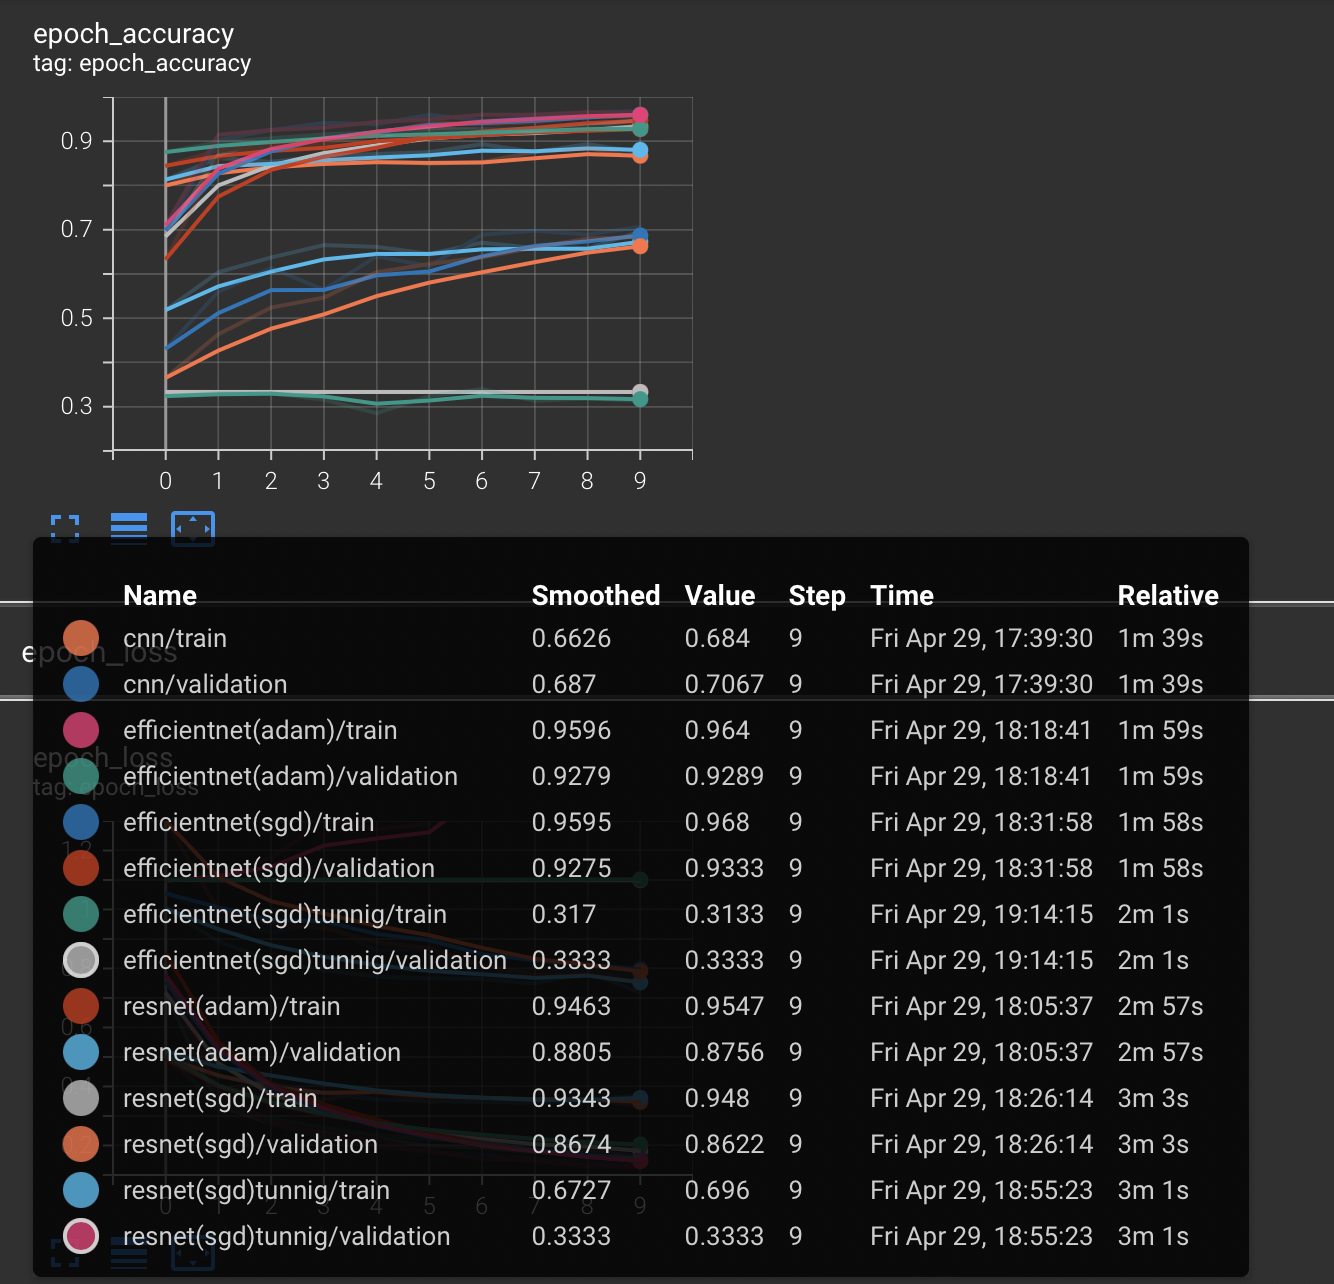

##Висновок:
В ході лабораторної роботи я навчилась вирішувати задачі класифікації для 3 класів з набору даних food101 з використанням різних моделей нейронних мереж, найкращим в результаті виявилась мережа Efficientnet(adam).